In [1]:
import re
import time
from datetime import datetime

import requests
from bs4 import BeautifulSoup
from selenium import webdriver

from IPython.display import Image
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

from pykrx import stock
import FinanceDataReader as fdr
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
import FinanceDataReader as fdr
import finterstellar as fs


import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
#plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

pd.set_option('max_colwidth', None)
plt.rcParams['font.family']

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


['Malgun Gothic']

# 무위험 자산 
* 단리
* 복리(이산형) == (1+r)**N
* 복리(연속형)

In [5]:
import math

r= 0.1
n= 10
X = 1000 
print(1000 * math.e**(r*n))
print(1000 * np.exp(r*n))

2718.2818284590453
2718.2818284590453


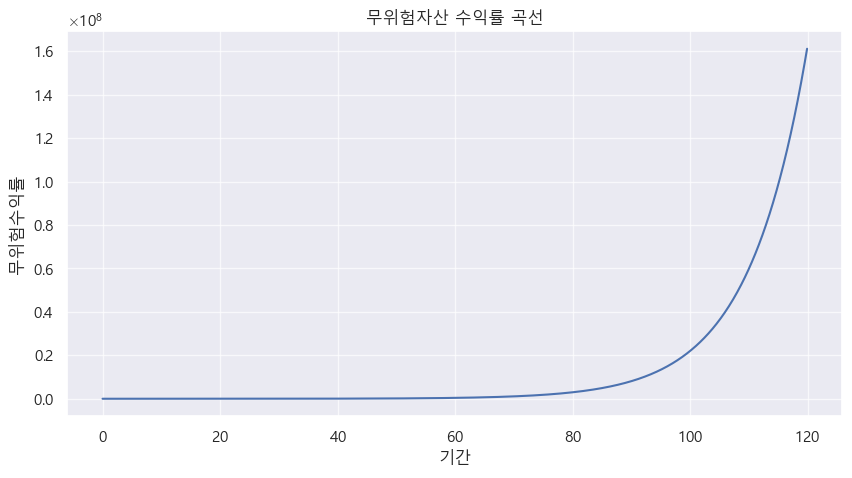

In [19]:
def risk_free_value(X,r,n):
    return X*math.e**(r*n)
n  = np.array([m for m in np.arange(0,120,0.1)])   

r = 0.1
X = 1000.00
res_arr  = risk_free_value(X,r,n)
plt.plot(n, res_arr)
plt.title("무위험자산 수익률 곡선")
plt.xlabel("기간")
plt.ylabel("무위험수익률")
plt.show()

In [8]:
risk_free_value(1000,0.1, 10)

2718.2818284590453

In [22]:
T = 1
N = 1000
dt = T / N
sqrt_dt = np.sqrt(dt) 

In [23]:
# Generate Series of 1) Time, 2) White Noise & 3) Brownian Motion
t = np.array([i for i in np.arange(0, T, T/N)])
dX = np.random.randn(N) * sqrt_dt
X = np.cumsum(dX)

[1101.94357006 1108.28733566 1117.29602793 1077.05370485 1099.37312368]


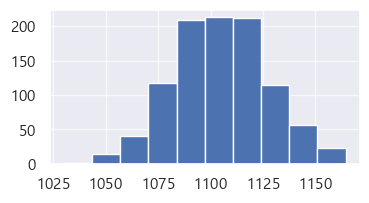

In [27]:
S0 = 1000
mu = 0.1 #drift(장기적추세) 시장의 무위험 이자률: 단기채권금리, CD금리 
sigma = 0.02 #diffusion(단기적변동)
T=1

St = S0 * np.exp((mu - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * np.random.randn(N))
print(St[:5])

plt.figure(figsize = (4,2))
plt.hist(St)
plt.show()

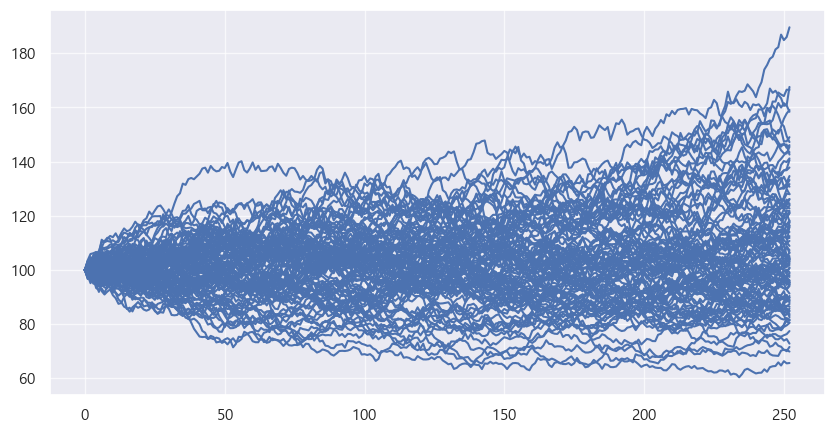

In [34]:
S0 = 100                  # 초기가격(Initial Price)
mu = 0.1                  # 추세(Drift)
sigma = 0.23              # 변동성(Volatility)
T = 1.0                   # 만기(Time to Maturity)
N = 100                   # 시뮬레이션 횟수
D = 252                   # 1년영업일수
dt = T / D                # 일의 연율화
S = np.zeros((D + 1, N))  # (253, 10000)
S[0] = S0                 # 초기가격
for t in range(1, D + 1): # 위험자산 수익률
    
    S[t] = S[t-1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * np.random.randn(N))
    
    
plt.plot(S, c='b')
plt.show()

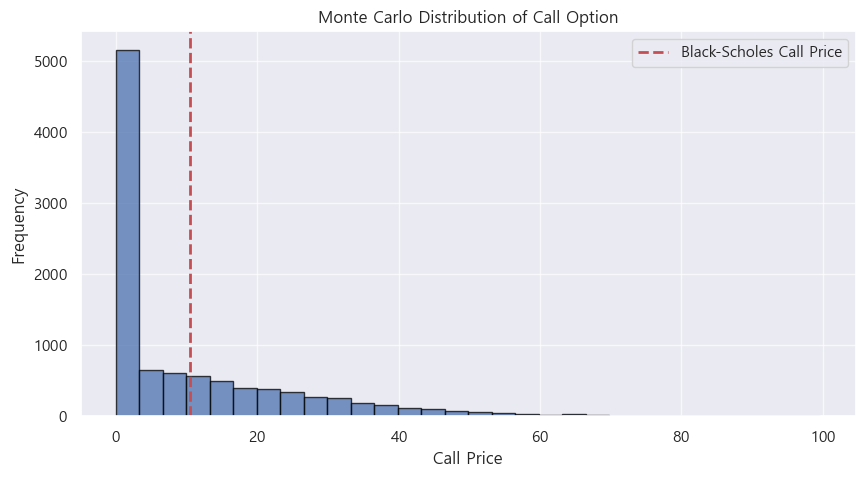

In [33]:
from scipy.stats import norm

def black_scholes_call(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def monte_carlo_call(S, K, r, sigma, T, num_simulations):
    dt = T / 252  # Assuming 252 trading days in a year
    S_T = np.zeros(num_simulations)
    for i in range(num_simulations):
        epsilon = np.random.normal(0, 1)
        S_T[i] = S * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * epsilon)
    call_price = np.exp(-r * T) * np.maximum(S_T - K, 0)
    return call_price

# Parameters
S = 100  # Underlying asset price
K = 100  # Strike price
r = 0.05  # Risk-free interest rate
sigma = 0.2  # Volatility
T = 1  # Time to maturity
num_simulations = 10000  # Number of Monte Carlo simulations

# Calculate call prices
bs_call_price = black_scholes_call(S, K, r, sigma, T)
mc_call_prices = monte_carlo_call(S, K, r, sigma, T, num_simulations)

# Plotting
plt.hist(mc_call_prices, bins=30, edgecolor='black', alpha=0.75)
plt.axvline(x=bs_call_price, color='r', linestyle='--', linewidth=2, label='Black-Scholes Call Price')
plt.xlabel('Call Price')
plt.ylabel('Frequency')
plt.title('Monte Carlo Distribution of Call Option')
plt.legend()
plt.show()


In [92]:
from scipy.stats import norm
import datetime

S = 1000  
K = 1300  
r = 0.25  
sigma = 0.2  
t = datetime.datetime.today().day
T = datetime.datetime.today().day+50

def black_scholes_call(S, K, r, sigma, t, T):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * (T-t)) / (sigma * np.sqrt(T-t))
    d2 = d1 - sigma * np.sqrt(T-t)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * (T-t)) * norm.cdf(d2)
    return call_price
    
def black_scholes_put(S, K, r, sigma, t, T):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * (T-t)) / (sigma * np.sqrt(T-t))
    d2 = d1 - sigma * np.sqrt(T-t)
    put_price = K * np.exp(-r * (T-t)) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

In [93]:
T

65

In [94]:
black_scholes_call(1000, 1300, 0.25, 0.2, t,T)

999.9951553508763

In [95]:
black_scholes_put(1000, 1300, 0.25, 0.2, t,T)

6.873510290148217e-19

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

def black_scholes_call(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def black_scholes_put(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

def monte_carlo_call(S, K, r, sigma, T, num_simulations):
    dt = T / 252  # Assuming 252 trading days in a year
    S_T = np.zeros(num_simulations)
    for i in range(num_simulations):
        epsilon = np.random.normal(0, 1)
        S_T[i] = S * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * epsilon)
    call_price = np.exp(-r * T) * np.maximum(S_T - K, 0)
    return call_price

def monte_carlo_put(S, K, r, sigma, T, num_simulations):
    dt = T / 252  # Assuming 252 trading days in a year
    S_T = np.zeros(num_simulations)
    for i in range(num_simulations):
        epsilon = np.random.normal(0, 1)
        S_T[i] = S * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * epsilon)
    put_price = np.exp(-r * T) * np.maximum(K - S_T, 0)
    return put_price

S = 100  
K = 100  
r = 0.05  
sigma = 0.2  


current_date = pd.Timestamp.now()
T = pd.offsets.BDay(50).apply(current_date).date()

num_simulations = 10000  


bs_call_price = black_scholes_call(S, K, r, sigma, T)
bs_put_price = black_scholes_put(S, K, r, sigma, T)
mc_call_prices = monte_carlo_call(S, K, r, sigma, T, num_simulations)
mc_put_prices = monte_carlo_put(S, K, r, sigma, T, num_simulations)


plt.subplot(1, 2, 1)
plt.hist(mc_call_prices, bins=30, edge)


SyntaxError: positional argument follows keyword argument (2860687235.py, line 55)